# Drugs ratio is node size instead of ketamine

Drugs: 

amphetamine

cocaine

meth

morphine

Nicotine

In [1]:
node_input =['PL', 'ILA', 'ORB', 'GU', 'AI', 'MOs', 'MOp','GPe','GPi','STRd','PALv',
             'BST','MEA', 'AAA', 'NLOT', 'COA', 'BMA', 'NDB','PVH','LH','MH','CEA',
             'LHA','ZI','DR','PAG','LDT','PB','CBN','ACB','LPO','MPO','MS','LSX']#,'MA','EPv']
#MA and EPv excluded because there are no injections into them
#anterior cortex = 'PL', 'ILA', 'ORB', 'GU', 'AI', 'MOs', 'MOp' - need to aggregate
#NAc = needs to be split into core, lateral, medial
#EAM =sum MEA, AAA, NLOT, COA, MA, BMA, EPv, NDB- need to aggregate ( there are No injections into MA or EPv)
#PO =  MPO and LPO- need to aggregate
#septum = LSX and MS- need to aggregate
# DR = sum DR and PAG
#do you want wildtype mice or cre mice? False = wildtype, True = transgenic mice, None = all mice
cre_FT_input = None

#what hemisphere of the brain do you want? 1 = left hemisphere, 2 = right hemisphere, 3 = both
which_hemi = 3

#do you want to drop low values/exclude them from plots? 
#Type True if so
#False if no (meaning you want all values to be plotted even if they're TINY).
drop_lows = True

#if the above is False, this value below is ignored
#what bottom percent of values do you want to drop? for bottom 10% type 10, for 5% type 5, etc.
consider_zero = 30

#what top percent of values do you want to consider large? not too important but will produce slightly different visuals for last plot
#for top 20% type 20, etc.
consider_big = 10

Cell below imports all packages/libraries necessary

In [2]:
#will use networkx in later cells to look at connections
#you must install everything (allensdk was tricky for me) before running this 
#lots of this code is copied and/or modified from the allensdk mouse connectivity jupyter notebook example online or from pieter's prototypes
import pandas as pd 
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import seaborn as sns
import networkx as nx
import itertools
import numpy
import matplotlib.pyplot as plt
import matplotlib as mpl

C:\Users\Kat\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Kat\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Kat\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


The cell below downloads the allen atlas data, defines the structure tree class (useful), gives a list of all the experiments (we will use this later) and also a dictionary of the structure ids to the corresponding structure acronym.

In [3]:
# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')
# open up a list of all of the experiments
all_experiments = mcc.get_experiments(dataframe=True)
# grab the StructureTree instance (class?)
structure_tree = mcc.get_structure_tree()
#get the list of ids that correspond to acronyms
id_acronym = structure_tree.get_id_acronym_map()

In [4]:
#function to get list of injections from certain type of mouse, certain region of brain
#First argument is True or False and corresponds to whether you want wildtype (False) or transgenic(cre) mice (True)
#Second argument is the abbreviation of the brain region you want the injection site to be - make string in quotes
def get_injections(creFT, region):
    acronyms = structure_tree.get_structures_by_acronym([region])[0]
    df1 = mcc.get_experiments(cre=creFT, 
                                       injection_structure_ids=[acronyms['id']])
    return pd.DataFrame(df1)
#This is actually not used in this code at all but it is useful if you need to check things later so I will leave it

In [5]:
import os
import nrrd
from allensdk.api.queries.ontologies_api import OntologiesApi
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi
from allensdk.config.manifest import Manifest
from allensdk.core.structure_tree import StructureTree
oapi = OntologiesApi()
structure_graph = oapi.get_structures_with_sets([1])  # 1 is the id of the adult mouse structure graph

# This removes some unused fields returned by the query
structure_graph = StructureTree.clean_structures(structure_graph)  

# the annotation download writes a file, so we will need somwhere to put it
annotation_dir = 'annotation'
Manifest.safe_mkdir(annotation_dir)
annotation_path = os.path.join(annotation_dir, 'annotation.nrrd')
# this is a string which contains the name of the latest ccf version
annotation_version = MouseConnectivityApi.CCF_VERSION_DEFAULT
mcapi = MouseConnectivityApi()
mcapi.download_annotation_volume(annotation_version, 25, annotation_path)
annotation, meta = nrrd.read(annotation_path)
tree = StructureTree(structure_graph)
from allensdk.core.reference_space import ReferenceSpace
# build a reference space from a StructureTree and annotation volume, the third argument is 
# the resolution of the space in microns
rsp = ReferenceSpace(tree, annotation, [25, 25, 25])

2022-03-18 23:24:52,402 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_25.nrrd


In [6]:
calc_proj_dens_sorted=pd.read_csv('data/allen_connectivities.csv',index_col=0)

In [7]:
# test that we have the right regions

regions_test = numpy.array(['PL', 'ILA', 'ORB', 'GU', 'AI', 'MOs', 'MOp','GPe','GPi','STRd','PALv',
             'BST','MEA', 'AAA', 'NLOT', 'COA', 'BMA', 'NDB','PVH','LH','MH','CEA',
             'LHA','ZI','DR','PAG','LDT','PB','CBN','ACB','LPO','MPO','MS','LSX'])

In [8]:
regions_test2 = calc_proj_dens_sorted.source.value_counts().index.values

In [9]:
set(regions_test2) - set(regions_test)

{'VTA'}

In [10]:
calc_proj_dens_sorted = calc_proj_dens_sorted[calc_proj_dens_sorted.source != "VTA"]
calc_proj_dens_sorted = calc_proj_dens_sorted[calc_proj_dens_sorted.target != "VTA"]
regions_test3 = calc_proj_dens_sorted.source.value_counts().index.values

set(regions_test3) - set(regions_test)

set()

In [11]:
#make a dataframe of node to same node projection which we will make zero for all
self_zero_data = pd.DataFrame()
for node1 in node_input:
    new_self_df = {'source':[node1], 'target' :[node1], 'normalized_projection_density_plus_sourceVOL':[0]}
    self_zero_df = pd.DataFrame(new_self_df) 
    self_zero_data= pd.concat([self_zero_data,self_zero_df])

In [12]:
#get averages for each source to target relationship
grouped_multiple = calc_proj_dens_sorted.groupby(['source', 'target']).agg({'normalized_projection_density_plus_sourceVOL': ['mean']})
grouped_multiple.columns = ['normalized_projection_density_plus_sourceVOL']
grouped_multiple = grouped_multiple.reset_index()

ALL Weights calculated by normalized_projection_density_average

In [13]:
#combine the source to target and the source to self average dataframes
ALLnormdensity_averages = pd.concat([grouped_multiple,self_zero_data])
ALLnormdensity_averages

source target  normalized_projection_density_plus_sourceVOL
0     AAA    ACB                                  1.656854e-03
1     AAA     AI                                  1.475624e-03
2     AAA    BMA                                  4.434615e-03
3     AAA    BST                                  1.363276e-03
4     AAA    CBN                                  5.581398e-08
..    ...    ...                                           ...
0     ACB    ACB                                  0.000000e+00
0     LPO    LPO                                  0.000000e+00
0     MPO    MPO                                  0.000000e+00
0      MS     MS                                  0.000000e+00
0     LSX    LSX                                  0.000000e+00

[1156 rows x 3 columns]

In [14]:
#copy of pieter's code. defines nodes of graphs (will be displayed as acronyms).
G = nx.DiGraph()
#below define nodes from source
nodes=node_input
idx=list(range(0,len(nodes)))

#G.add_nodes_from(idx)
G.add_nodes_from(nodes)
print(nodes)

['PL', 'ILA', 'ORB', 'GU', 'AI', 'MOs', 'MOp', 'GPe', 'GPi', 'STRd', 'PALv', 'BST', 'MEA', 'AAA', 'NLOT', 'COA', 'BMA', 'NDB', 'PVH', 'LH', 'MH', 'CEA', 'LHA', 'ZI', 'DR', 'PAG', 'LDT', 'PB', 'CBN', 'ACB', 'LPO', 'MPO', 'MS', 'LSX']


In [15]:
#adds edges to G from the average normalized projection densities for each source -> target relationship
for (x,y) in itertools.product(node_input,node_input):
    query_df = ALLnormdensity_averages[ALLnormdensity_averages.source == x].copy()
    weight = query_df[query_df.target == y].normalized_projection_density_plus_sourceVOL.iloc[0]
    G.add_edge(x,y,weight=weight)

In [16]:
#remove edges if their weight is exactly zero (these are placeholder zeros that I put in. Data from allen won't be zero.)
ALLnormdensity_averages = ALLnormdensity_averages[ALLnormdensity_averages.normalized_projection_density_plus_sourceVOL != 0.0]
edge_weights = nx.get_edge_attributes(G,'weight')
if drop_lows == True:
    G.remove_edges_from((e for e, w in edge_weights.items() if w == 0.0))

In [17]:
#establish what large and zero are
consider_zero=30
large=numpy.percentile(ALLnormdensity_averages['normalized_projection_density_plus_sourceVOL'], 100-consider_big) 
#changed zero to 0.01 from 0.1
zero=numpy.percentile(ALLnormdensity_averages['normalized_projection_density_plus_sourceVOL'], consider_zero) 
print('large is over '+str(large))
print('zero is below '+str(zero))

large is over 0.013890399778575159
zero is below 0.0003477858328291609


In [18]:
#copy of pieter's prototype code
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > large]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if (d['weight'] <= large) & (d['weight'] > zero)]
ezero = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= zero]

In [19]:
#copy of pieter's prototype code
enonzero = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > zero]
weights=[d['weight'] for (u, v, d) in G.edges(data=True) if d['weight'] > zero]
print(len(elarge))
print(len(esmall))
print(len(ezero))

113
672
337


In [20]:
#copy of pieter's prototype code
max_weight=numpy.max(weights)

edge_colors = [w/max_weight for w in weights]
edge_alphas = [w/max_weight for w in weights]

len(weights)

785

In [21]:
#remove edges if their weight is in the specified bottom percentiles
edge_weights = nx.get_edge_attributes(G,'weight')
if drop_lows == True:
    G.remove_edges_from((e for e, w in edge_weights.items() if w < zero))

C:\Users\Kat\AppData\Local\Temp/ipykernel_8484/2169671966.py:18: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc)


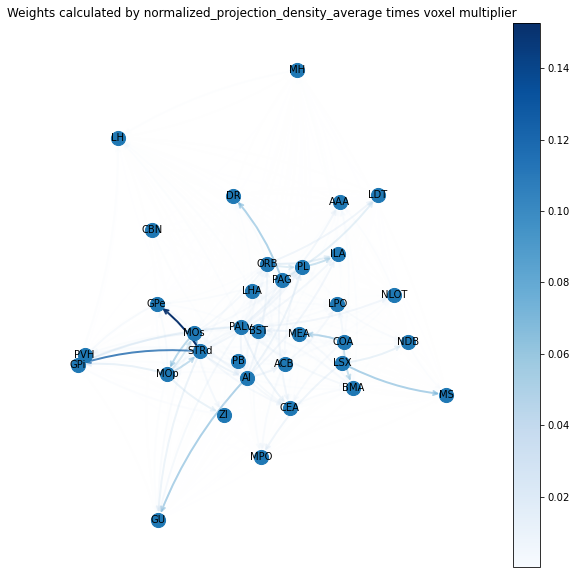

In [22]:
#copy of pieter's prototype code
pos = nx.spring_layout(G)
plt.figure(figsize=(10,10))
# nodes
nx.draw_networkx_nodes(G, pos, node_size=200)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif');

edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.Blues)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(weights)
plt.colorbar(pc)

plt.title('Weights calculated by normalized_projection_density_average times voxel multiplier')
ax = plt.gca()
ax.set_axis_off()
#plt.savefig("figures/allnodes-spring_layout_edges.svg")
plt.show()

C:\Users\Kat\AppData\Local\Temp/ipykernel_8484/3324961228.py:17: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc)


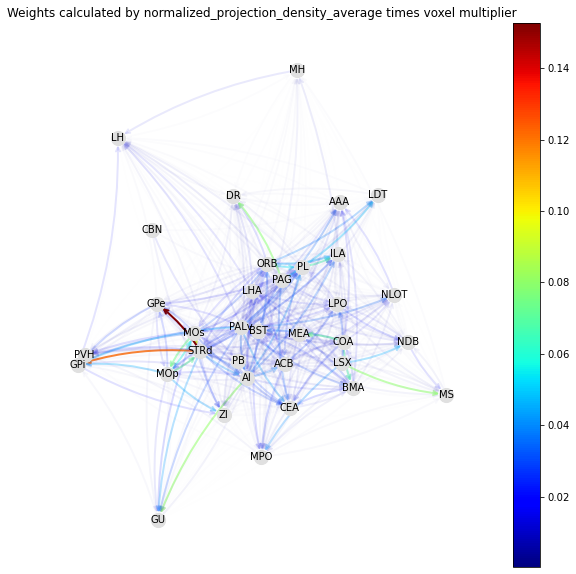

In [23]:
plt.figure(figsize=(10,10))

# nodes
nx.draw_networkx_nodes(G, pos, node_size=200,node_color='#E0E0E0')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.jet)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
    
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.jet)
pc.set_array(weights)
plt.colorbar(pc)

plt.title('Weights calculated by normalized_projection_density_average times voxel multiplier')
ax = plt.gca()
ax.set_axis_off()
#plt.savefig('figures/all_1.svg')
plt.show()

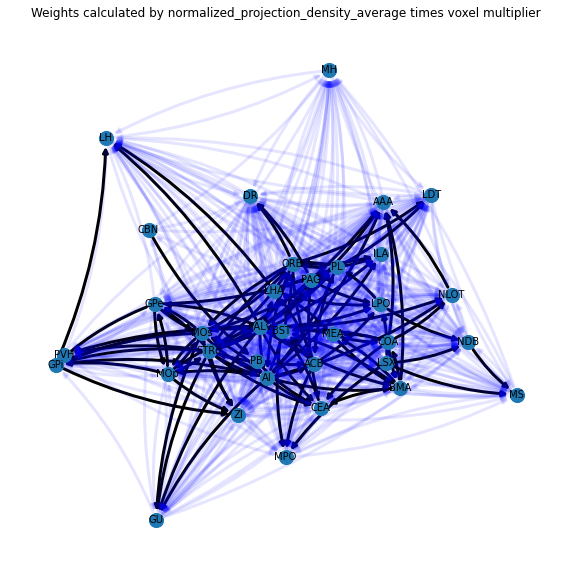

In [24]:
#copy of pieter's prototype code
plt.figure(figsize=(10,10))
# nodes
nx.draw_networkx_nodes(G, pos, node_size=200)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=3, connectionstyle='arc3, rad=0.1')
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=3, alpha=0.1, edge_color='b',
                      connectionstyle='arc3, rad=0.1')

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title('Weights calculated by normalized_projection_density_average times voxel multiplier')
plt.axis('off')
#plt.savefig('figures/all_2.svg')
plt.show()

C:\Users\Kat\AppData\Local\Temp/ipykernel_8484/1373562320.py:37: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc, orientation="horizontal", fraction=0.05)


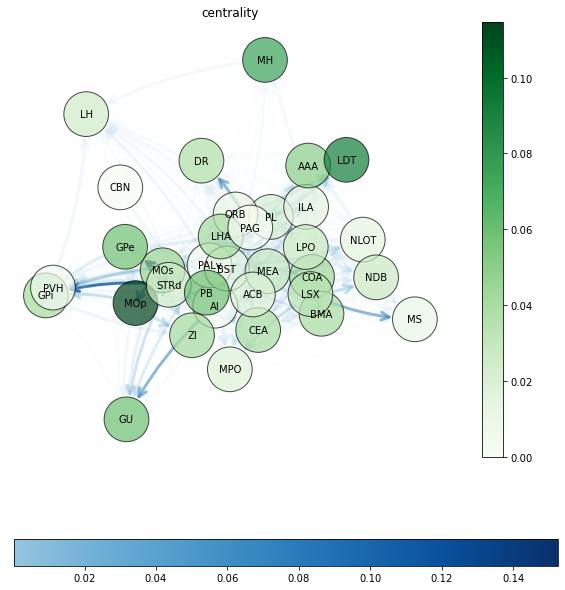

In [25]:
#nodes colored by centrality
#copy of pieter's prototype code
import matplotlib.colors as colors
#node_cen=nx.degree_centrality(G, k=None, normalized=True, weight='weight')
node_cen=nx.betweenness_centrality(G, k=None, normalized=True, weight='weight')
cen_scores=[]
for node in node_input:
    cen_scores.append(node_cen[node])
# draw the graph
# color the nodes according to their partition
cmap = plt.cm.get_cmap('Greens')
#norm = colors.Normalize(vmin=min(btw_scores),vmax=max(btw_scores))
# edges
plt.figure(figsize=(10,10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=2000,
                       cmap=cmap, alpha=0.7,node_color=cen_scores)
enonzero = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > zero]
weights=[d['weight'] for (u, v, d) in G.edges(data=True) if d['weight'] > zero]
max_weight=numpy.max(weights)
edge_colors = [w/max_weight for w in weights]
edge_alphas = [w/max_weight for w in weights]
edge_cmap=plt.cm.Blues
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(numpy.linspace(minval, maxval, n)))
    return new_cmap
edge_cmap=truncate_colormap(edge_cmap, 0.4, 1)
edges=nx.draw_networkx_edges(G, pos, node_size=2000, edgelist=enonzero,
                             arrowstyle='->', arrowsize=20, width=3,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=edge_cmap)
for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
pc = mpl.collections.PatchCollection(edges, cmap=edge_cmap)
pc.set_array(weights)
plt.colorbar(pc, orientation="horizontal", fraction=0.05)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(cen_scores), vmax=max(cen_scores)))
plt.colorbar(sm)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
plt.axis('off')
plt.title('centrality')
#plt.savefig('figures/all_3.svg')
plt.show()

C:\Users\Kat\AppData\Local\Temp/ipykernel_8484/724765090.py:27: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc)


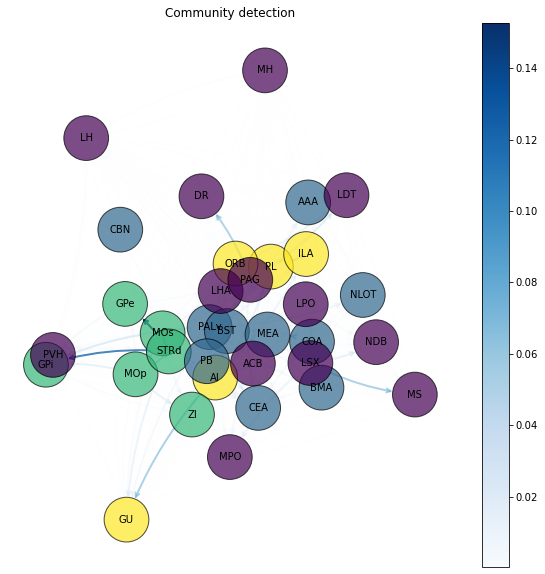

In [26]:
# ! pip install scikit-network # install if needed
from sknetwork.clustering import Louvain, modularity, bimodularity
import matplotlib.cm as cm

plt.figure(figsize=(10,10))

louvain = Louvain()
labels = louvain.fit_transform(nx.adjacency_matrix(G))

# nodes
cmap = cm.get_cmap('viridis', max(labels) + 1)
nodes = nx.draw_networkx_nodes(G, pos,  node_size=2000,
                       cmap=cmap, alpha=0.7,node_color=labels)
nodes.set_edgecolor('black')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

edges=nx.draw_networkx_edges(G, pos, node_size=2000, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.Blues)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(weights)
plt.colorbar(pc)

plt.title('Community detection')
ax = plt.gca()
ax.set_axis_off()
plt.savefig("figures/network-visualizations/networkx-louvain.svg")
plt.show()

# visualize with plotly, combining many features

In [27]:
! pip install plotly

In [28]:
import plotly
import plotly.graph_objects as go

In [29]:
for k in pos.keys():
    G.nodes[k]['pos']=pos[k]

In [30]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

In [31]:
louvain = Louvain()
labels = louvain.fit_transform(nx.adjacency_matrix(G))
cluster_probs = louvain.membership_.todense()

node_cen = nx.betweenness_centrality(G, k=None, normalized=True, weight='weight')
# node_cen = nx.degree_centrality(G)

cen_scores=[]
for node in node_input:
    cen_scores.append(node_cen[node])

In [32]:
fig = go.Figure(data=[edge_trace],#, node_trace],
             layout=go.Layout(
                title='Betweenness Centrality',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

cmap="viridis"
cmap=plt.get_cmap(cmap)
colors = cmap(numpy.linspace(0, 1, max(labels)+1))
colors_hex=[mpl.colors.rgb2hex(l) for l in colors]

#node_trace.marker.color = labels
node_text = [f'{labels[i]+1}: {node_input[i]}</br></br>{cluster_probs[i][0]}' for i in range(len(cen_scores))]

node_size = (numpy.array(cen_scores)*15/max(cen_scores))+20


for l in range(max(labels)+1):
        trace_node_x = numpy.array(node_x)[labels==l]
        trace_node_y = numpy.array(node_y)[labels==l]
        trace_text = [node_text[i] for i in range(len(node_x)) if labels[i]==l]
        trace_size = [node_size[i] for i in range(len(node_x)) if labels[i]==l]
        
        trace_color = colors_hex[l]
        fig.add_trace(go.Scatter(
            y=trace_node_y,
            x=trace_node_x,
            mode='markers',
            marker_color=trace_color,
            marker_size=trace_size,
            text=trace_text,
            hoverinfo="text"
        ))

for i in range(len(node_x)):
    fig.add_annotation(x=node_x[i], y=node_y[i],
                        text=node_input[i],showarrow=False)

plotly.io.write_html(fig, file=f'figures/network-visualizations/betweenness-louvain.html')
#plotly.io.write_image(fig, file=f'figures/network-visualizations/betweenness-louvain.png')

fig.show()

In [33]:
iso_means = pd.read_csv("data/iso_rabies_R.csv").mean()
drugs_means = pd.read_csv("data/am-co-me-mo-ni_rabies_R.csv").mean()

In [34]:
drugs_ratio = drugs_means / iso_means

In [35]:
drugs_ratio.index = [s.lstrip("%") for s in drugs_ratio.index]

In [36]:
drugs_ratio.index

Index(['ACB', 'Anterior Cortex', 'BNST', 'CeA', 'DCN', 'DR', 'DStr', 'EAM',
       'EP', 'GP', 'LDT', 'LH', 'LHb', 'MHb', 'PBN', 'PO', 'PVN', 'Septum',
       'VP', 'ZI'],
      dtype='object')

In [37]:
kevin_to_allen_mapping = {
    "Anterior Cortex": ["PL", "ILA", "ORB", "GU", "AI", "MOs", "MOp"],
    "BNST": ["BST"],
    "EAM": ["MEA", "AAA", "NLOT", "COA", "MA", "BMA", "EPv", "NDB" ],
    "DR": ["DR","PAG"],
    "ZI": ["ZI"],
    "PBN": ["PB"],
    "Gpe": ["GPe"],
    "Septum": ["LSX","MS"],
    "LDT":["LDT"],
    "VP":["PALv"],
    "PO":["MPO","LPO"],
    "PVN":["PVH"],
    "LH":["LHA"],
    "DCN":["CBN"],
    "ACB":["ACB"],
    "EP":["GPi"],
    "GP":["GPe"],
    "LHb":["LH"],
    "MHb":["MH"],
    "DStr":["STRd"],
    "CeA": ["CEA"],
    
}

In [38]:
outputs = []
for r in drugs_ratio.index:
    if r in kevin_to_allen_mapping.keys():
        for rr in kevin_to_allen_mapping[r]:
            outputs.append(rr)

In [39]:
print(set(node_input)-set(outputs))

set()


In [40]:
node_df = pd.DataFrame(index=node_input)
node_df['drugs rabies ratio'] = 0.0
node_df['kevin abbrv'] = [""]*len(node_input)
dict_allen_to_kevin = {}
for r in drugs_ratio.index:
    allen_regions = kevin_to_allen_mapping[r]
    for rr in allen_regions:
        if rr in node_df.index:
            node_df.loc[rr]["drugs rabies ratio"] = drugs_ratio[r]
            dict_allen_to_kevin[rr] = {}
            dict_allen_to_kevin[rr]['ratio'] = drugs_ratio[r]
            dict_allen_to_kevin[rr]['kevin abbrv'] = r

C:\Users\Kat\anaconda3\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
kevin_abbrvs = []
drugs_ratios = []
for n in node_input:
    kevin_abbrvs.append(dict_allen_to_kevin[n]['kevin abbrv'])
    drugs_ratios.append(dict_allen_to_kevin[n]['ratio'])
node_df['drugs rabies ratio'] = drugs_ratios
node_df['kevin abbrv'] = kevin_abbrvs
node_df.head()

drugs rabies ratio      kevin abbrv
PL             0.785056  Anterior Cortex
ILA            0.785056  Anterior Cortex
ORB            0.785056  Anterior Cortex
GU             0.785056  Anterior Cortex
AI             0.785056  Anterior Cortex

In [48]:
fig = go.Figure(data=[edge_trace],#, node_trace],
             layout=go.Layout(
                title='Drugs Ratio',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

cmap="viridis"
cmap=plt.get_cmap(cmap)
colors = cmap(numpy.linspace(0, 1, max(labels)+1))
colors_hex=[mpl.colors.rgb2hex(l) for l in colors]

#node_trace.marker.color = labels
node_text = [f'{labels[i]+1}: {node_input[i]}</br></br>{cluster_probs[i][0]}</br></br>drugs ratio: {drugs_ratios[i]}' 
             for i in range(len(cen_scores))]

node_size = (numpy.array(drugs_ratios)*20/max(drugs_ratios))+20


for l in range(max(labels)+1):
        trace_node_x = numpy.array(node_x)[labels==l]
        trace_node_y = numpy.array(node_y)[labels==l]
        trace_text = [node_text[i] for i in range(len(node_x)) if labels[i]==l]
        trace_size = [node_size[i] for i in range(len(node_x)) if labels[i]==l]
        
        trace_color = colors_hex[l]
        fig.add_trace(go.Scatter(
            y=trace_node_y,
            x=trace_node_x,
            mode='markers',
            marker_color=trace_color,
            marker_size=trace_size,
            text=trace_text,
            hoverinfo="text"
        ))

for i in range(len(node_x)):
    fig.add_annotation(x=node_x[i], y=node_y[i],
                        text=node_input[i],showarrow=False)

plotly.io.write_html(fig, file=f'figures/network-visualizations/drugsratio-louvain.html')
plotly.io.write_image(fig, file=f'figures/network-visualizations/drugsratio-louvain.png')
plotly.io.write_image(fig, file=f'figures/network-visualizations/drugsratio-louvain.svg')

fig.show()